In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

In [ ]:
image_size = (150, 150)

In [ ]:
#обучающий и валидационный датасеты
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "plates/train",
    validation_split=0.3,
    subset="training",
    seed=1307,
    image_size=image_size,
    batch_size=32
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "plates/train",
    validation_split=0.3,
    subset="validation",
    seed=1307,
    image_size=image_size,
    batch_size=32
)

Found 40 files belonging to 2 classes.
Using 28 files for training.
Found 40 files belonging to 2 classes.
Using 12 files for validation.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for images, labels in train_ds.take(1):
  for i in range(1):
    print(images[i])
    print(labels[i])

tf.Tensor(
[[[1.83217125e+01 1.43217106e+01 1.13217106e+01]
  [1.72351341e+01 1.32351341e+01 1.02351341e+01]
  [1.66366673e+01 1.26366663e+01 9.63666630e+00]
  ...
  [1.22313072e+02 1.08846397e+02 8.93797226e+01]
  [1.16300873e+02 1.01300873e+02 8.03008728e+01]
  [1.13631088e+02 9.86310883e+01 7.76310883e+01]]

 [[2.06466675e+01 1.66466675e+01 1.36466665e+01]
  [1.89946003e+01 1.50491991e+01 1.19400005e+01]
  [1.89099998e+01 1.58889999e+01 1.09309998e+01]
  ...
  [1.29131302e+02 1.15664627e+02 9.61979523e+01]
  [1.16716179e+02 1.01716179e+02 8.07161789e+01]
  [1.14216583e+02 9.92165833e+01 7.82165833e+01]]

 [[2.40647774e+01 1.90647774e+01 1.46981106e+01]
  [2.45499992e+01 1.95499992e+01 1.50853338e+01]
  [2.45499992e+01 1.95499992e+01 1.35500002e+01]
  ...
  [1.25630005e+02 1.12163330e+02 9.26966553e+01]
  [1.22774323e+02 1.07774323e+02 8.67743225e+01]
  [1.17939331e+02 1.02939331e+02 8.19393311e+01]]

 ...

 [[1.69156876e+01 1.47813358e+01 8.41942024e+00]
  [1.75595665e+01 1.46575632

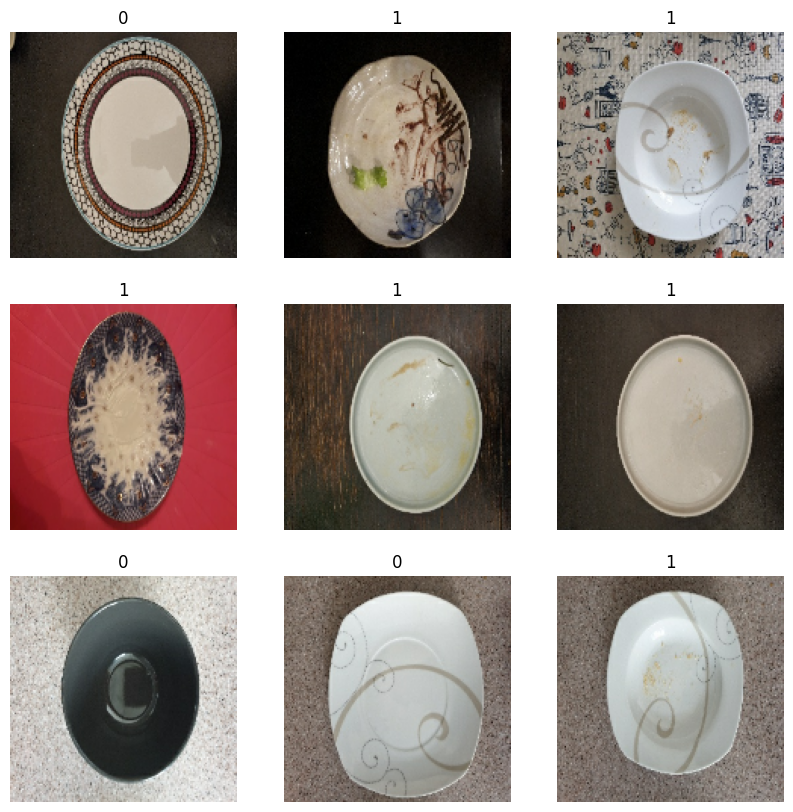

In [ ]:
#несколько примеров тарелок
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#аугментация изображений
data_augmentation = keras.Sequential(
[
    layers.experimental.preprocessing.RandomFlip("horizontal"), #поворот
    layers.experimental.preprocessing.RandomRotation(0.3), #вращение
    layers.experimental.preprocessing.RandomZoom(0.3), #зум
    layers.experimental.preprocessing.RandomContrast(0.8) #контрастность
]
)

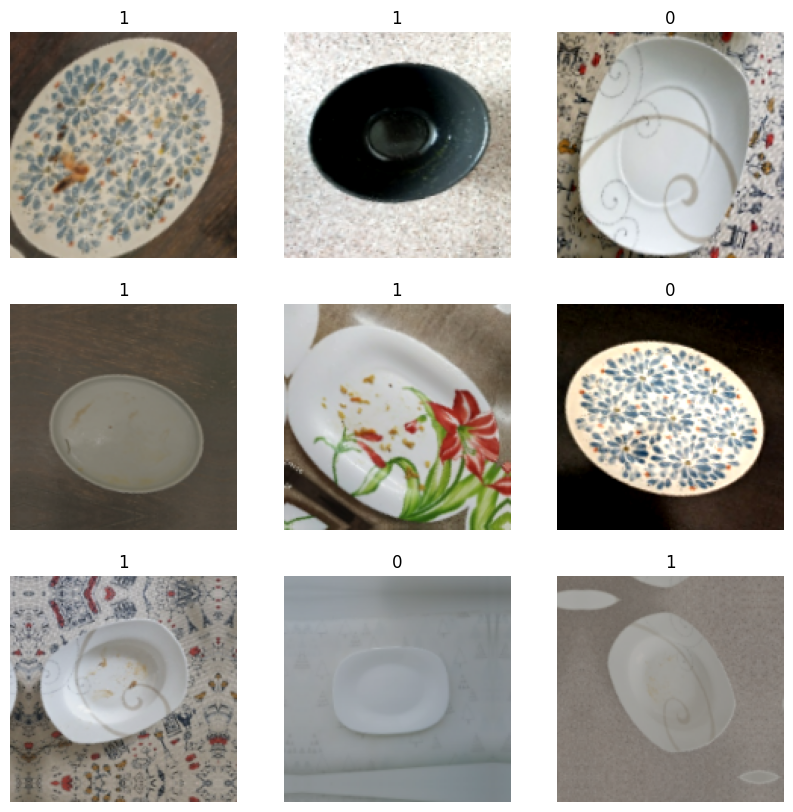

In [ ]:
#пример тарелок после аугментации
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#применяем аугментацию для изображени и увеличиваем за счет этого наборы данных
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y)).repeat(300).shuffle(32)

augmented_val_ds = val_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y)).repeat(20).shuffle(32)

In [ ]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = augmented_val_ds.prefetch(buffer_size=32)

In [ ]:
len(train_ds)

300

## Сверточные нейронные сети

Теория - https://practicum.yandex.ru/blog/svertochnye-neyronnye-seti/

Немного практики - https://proproprogs.ru/neural_network/delaem-svertochnuyu-neyronnuyu-set-v-keras

In [ ]:
def make_model(input_shape):
  model=Sequential()
  model.add(keras.Input(shape=input_shape))
  model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
  model.add(layers.Conv2D(128, 3, strides=2, padding="same",activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Dense(64,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

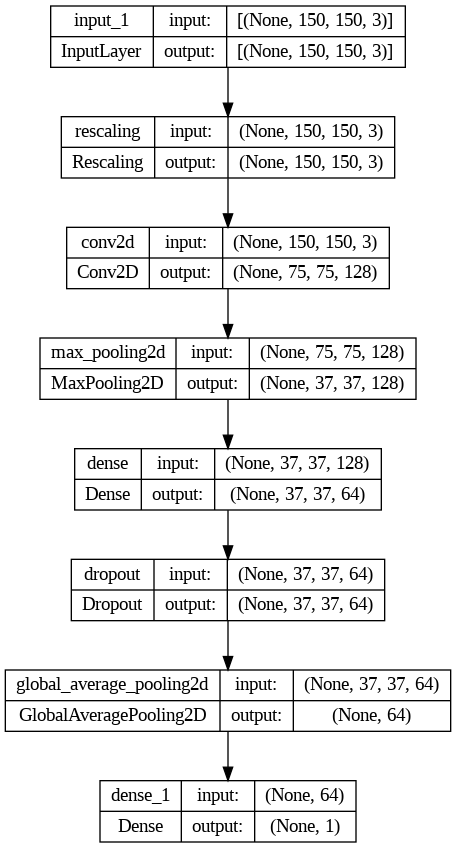

In [ ]:
model = make_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

model_cp = keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    augmented_train_ds, epochs=epochs, callbacks=[model_cp, earlystop], validation_data=augmented_val_ds
)

Epoch 1/10
300/300 [==============================] - 65s 159ms/step - loss: 0.6126 - accuracy: 0.6002 - val_loss: 1.1864 - val_accuracy: 0.4542
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 53s 158ms/step - loss: 0.5773 - accuracy: 0.6654 - val_loss: 1.2975 - val_accuracy: 0.4333
Epoch 3/10
300/300 [==============================] - 53s 161ms/step - loss: 0.5519 - accuracy: 0.7008 - val_loss: 1.4527 - val_accuracy: 0.4125
Epoch 4/10
300/300 [==============================] - 55s 167ms/step - loss: 0.5325 - accuracy: 0.7120 - val_loss: 1.5302 - val_accuracy: 0.4375
Epoch 5/10
300/300 [==============================] - 56s 168ms/step - loss: 0.5155 - accuracy: 0.7131 - val_loss: 1.7036 - val_accuracy: 0.3667
Epoch 6/10
300/300 [==============================] - 56s 170ms/step - loss: 0.4963 - accuracy: 0.7318 - val_loss: 1.6991 - val_accuracy: 0.4667
Epoch 7/10
300/300 [==============================] - 56s 171ms/step - loss: 0.4807 - accuracy: 0.7425 - val_loss: 1.7681 - val_accuracy: 0.4458
Epoch 8/10
300/300 [==============================] - 56s 170ms/step - loss: 0.4620 - accuracy: 0.7606 - val_loss: 1.8127 - val_accuracy: 0.5

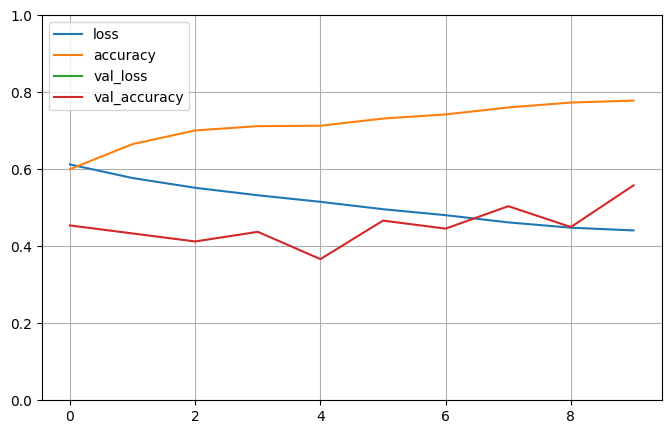

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## ЛР Классификация изображений - 10 баллов

* требования к набору данных - минимум 100 изображений (но чем больше, тем лучше)
* аугментация изображений (повороты, зум, контрастность) - минус 2 балла за использование дефолтных параметров (те, которые даны у меня в записке)
* построение 3 моделей разных архитектур (количество слоев/нейронов) - проверить качество каждой из моделей на валидационной/тестовой выборках - какая из моделей оказалась лучше?
* классика жанра - confusion_matrix and classification_report со всеми выводами
* две функции - одна превращает картинку в numpy-массив нужной длины, вторая возвращает прогноз с использованием ранее обученной модели